In [71]:
import pandas as pd
%matplotlib inline
import pylab as pl

In [72]:
import numpy as np
from io import open
import seaborn as sns
import Levenshtein
from collections import Counter

In [73]:
orecs=[]
f = open('./data/clippings_analysis.txt')
for l in f:
    tokens=l.strip().split(' ')
    orecs.append((tokens[0], u' '.join(tokens[1:]).strip()))
df=pd.DataFrame().from_records(orecs, columns=['clipping','full'])
df.to_csv('./data/clippings_analysis.csv', sep='\t', encoding='utf-8')

In [74]:
df_clipping_only=pd.read_csv('./data/only_clippings_gold.phonemes', sep='\t', skiprows=3, header=None, names=['word','phonemes'])

In [75]:
def get_num_syllables(v):
    vowels=set(['AA','AE','AH','AO','AW','AY','EH','ER','EY','IH','IY','OW','OY','UH','UW'])
    phonemes=v.split(' ')
    cv=0
    for p in phonemes:
        if p in vowels:
            cv=cv+1
    return cv

In [76]:
def clip_helper(v, num_syllables=2, ctype='BACK'):
    vowels=set(['AA','AE','AH','AO','AW','AY','EH','ER','EY','IH','IY','OW','OY','UH','UW'])
    phonemes=v.split(' ')        
    cv=0
    output=[]
    if ctype=='BACK':
        for p in phonemes:
            if p in vowels:
                cv=cv+1
                if cv > num_syllables:
                    break
            output.append(p)
    elif ctype == 'FORE':
        phonemes_v=' '.join(phonemes[::-1])
        cp = clip_helper(phonemes_v, num_syllables, ctype='BACK')
        output = cp.split(' ')[::-1]
    return ' '.join(output)

In [77]:
def clip(v, num_syllables=2):
    vowels=set(['AA','AE','AH','AO','AW','AY','EH','ER','EY','IH','IY','OW','OY','UH','UW'])
    phonemes=v.split(' ')
    ctype=global_pmf.sample()
    if '@' in v: # compound clippins
        part1=v.split('@')[0]
        part2=v.split('@')[1]
        part1_phonemes = part1.strip().split(' ')
        part2_phonemes = part2.strip().split(' ')
        part1_clip=clip_helper(' '.join(part1_phonemes), num_syllables=1)
        part2_clip=clip_helper(' '.join(part2_phonemes), num_syllables=1)
        print v, part1_clip, part1_phonemes, part2_clip, part2_phonemes
        assert '@' not in part1_clip
        assert '@' not in part2_clip

        return part1_clip + ' ' + part2_clip
    else:
        return clip_helper(v, num_syllables, ctype=ctype)


In [78]:
def random_clip(v, num_syllables=2):
    vowels=set(['AA','AE','AH','AO','AW','AY','EH','ER','EY','IH','IY','OW','OY','UH','UW'])
    v=v.replace('@',' ')
    phonemes=v.split(' ')
    keep_length=np.random.randint(1, len(v)+1)
    return ' '.join(phonemes[:keep_length])

In [79]:
df_clipping_only["num"]=[get_num_syllables(ps) for ps in df_clipping_only.phonemes.values] 

In [80]:
df_components_only=pd.read_csv('./data/only_clippings_full_components_gold.phonemes', sep='\t', skiprows=3, header=None, names=['word','phonemes'])

In [81]:
df_components_only["num"]=[get_num_syllables(ps) for ps in df_components_only.phonemes.values] 

In [82]:
df_components_only.num.describe()

count    576.000000
mean       3.302083
std        1.417553
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max       14.000000
Name: num, dtype: float64

In [83]:
df_clipping_only.num.describe()

count    576.000000
mean       1.557292
std        0.601606
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: num, dtype: float64

In [84]:
class Pmf(Counter):
    """A Counter with probabilities."""

    def normalize(self):
        """Normalizes the PMF so the probabilities add to 1."""
        total = float(sum(self.values()))
        for key in self:
            self[key] /= total

    def __add__(self, other):
        """Adds two distributions.

        The result is the distribution of sums of values from the
        two distributions.

        other: Pmf

        returns: new Pmf
        """
        pmf = Pmf()
        for key1, prob1 in self.items():
            for key2, prob2 in other.items():
                pmf[key1 + key2] += prob1 * prob2
        return pmf

    def __hash__(self):
        """Returns an integer hash value."""
        return id(self)
    
    def __eq__(self, other):
        return self is other

    def render(self):
        """Returns values and their probabilities, suitable for plotting."""
        return zip(*sorted(self.items()))
    
    def sample(self):
        keys, vals= zip(*self.items())
        return np.random.choice(keys, p=vals)

In [85]:
from collections import Counter
syllable_counter_clippings=Counter(df_clipping_only.num.values)
syllable_counter_clippings_pmf = Pmf(syllable_counter_clippings)

In [86]:
syllable_counter_clippings_pmf.normalize()

In [87]:
def plot_counter_err(c, xlabel, ylabel, topk=10, ymax=0.6, color_dict=None, use_constant_color=False):
    import statsmodels.api as sm
    z=c.most_common()
    print "Sum", sum(zip(*z)[1])
    sfixes=list(zip(*z)[0])
    svals=list(zip(*z)[1])
    evals = sm.stats.multinomial_proportions_confint(np.array(svals))
    print "Evals", evals.shape
    nc=Pmf(c)
    nc.normalize()
    nz=nc.most_common()
    nsvals = list(zip(*nz)[1])
    lerrs=np.array(nsvals)-evals[:,0] #CI is not necessarily symmetrical
    herrs=evals[:,1]-np.array(nsvals)
    errs=np.array([lerrs,herrs])
    cmap=sns.light_palette("purple", reverse=True, n_colors=25)
    if use_constant_color == False:
        g=sns.barplot(sfixes[:topk], list(nsvals[:topk]),  capsize=0.2,palette=cmap,**{'yerr':errs[:,:topk]})
    else:
        g=sns.barplot(sfixes[:topk], list(nsvals[:topk]), palette=color_dict,capsize=0.2,**{'yerr':errs[:,:topk]})
    g.set_xticklabels(g.get_xticklabels(), rotation=0, fontsize=14)
    g.set_xlabel(xlabel, fontsize=14)
    g.set_ylabel(ylabel, fontsize=14)
    g.set_ylim((0,ymax))
    return g

Sum 576
Evals (4, 2)


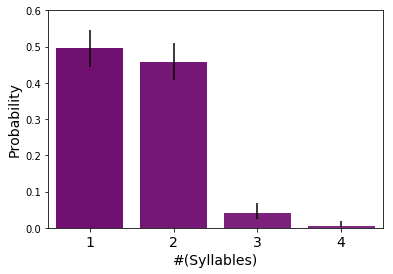

In [88]:
plot_counter_err(syllable_counter_clippings, '#(Syllables)', 'Probability')
pl.savefig('./figs/clippings_num_syllables.pdf', bbox_inches='tight')